# Re-cluster spikes detected with HS1

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from hs2 import herdingspikes
from probe import NeuralProbe, NeuroPixel, BioCam
import numpy as np

%matplotlib inline

/disk/scratch/mhennig/venvs/theano/lib64/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
Probe = BioCam()
H = herdingspikes(Probe)

Note: data file not specified, setting some defaults


In [3]:
path = '/data/MEA/LightStim/PVDREADD_P63_09_08_2016/'
path = '/disk/scratch/mhennig/PVDREADD_P63_09_08_2016/'
lfile = 'PVDREADD_P63_09_08_2016_stim1_basic_CTL_v28Format.hdf5'
# lfile = 'PVDREADD_P63_09_08_2016_stim2_SWN_CTL_v28Format.hdf5'
# path = '/data/MEA/LightStim/P29_16_07_14/HdfFilesSpkD45_dev/'
path = '/disk/scratch/mhennig//P29_16_07_14/HdfFilesSpkD45_dev/'
lfile = 'P29_16_05_14_retina01_right_stim2_smallarray_fullfield_v28_clustered_0.3_0.34_align_multi.hdf5'
# lfile = 'P29_16_05_14_retina01_right_stim1_smallarray_whitenoise100ms_v28_clustered_0.3_0.38_multi.hdf5'
H.Load_HDF5_legacy(path+lfile, chunk_size=1000000, compute_amplitudes=False)

Reading from /disk/scratch/mhennig//P29_16_07_14/HdfFilesSpkD45_dev/P29_16_05_14_retina01_right_stim2_smallarray_fullfield_v28_clustered_0.3_0.34_align_multi.hdf5
Creating memmapped cache for shapes, reading in chunks, converting to integer...
Found 6775 data points out of linear regime in chunk 1
Found 279092 spikes in 1525 units...
...done.


We have 279092 spikes, only showing 200000


(30.765829536137186,
 65.216256645503449,
 30.747473381441072,
 65.218224860746417)

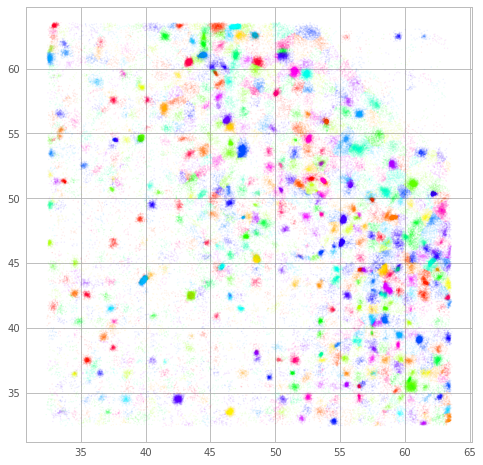

In [4]:
# overview
plt.figure(figsize=(8, 8))
H.PlotAll(invert=True, s=1, alpha=0.05)
plt.axis('equal')

# Spike sorting

In [5]:
%%time
# There are several methods available now

# mean shift
H.CombinedClustering(bandwidth=0.3, bin_seeding=True, alpha=0.3,
                    min_bin_freq=10, pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

# DBScan
# from sklearn.cluster import DBSCAN
# H.CombinedClustering(eps=0.2, alpha=0.4, clustering_algorithm=HDBSCAN,
#                     min_samples=5, pca_ncomponents=2, pca_whiten=True,
#                     n_jobs=-1)

# HDBScan, best results, slower (?)
# import hdbscan
# # H.CombinedClustering(min_cluster_size=10, alpha=0.6, clustering_algorithm=HDBSCAN,
# #                     min_samples=5, pca_ncomponents=2, pca_whiten=True)


Fitting PCA using 279092 spikes...
Clustering...
total number of seeds: 5637
seeds/job: 470
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   23.9s remaining:  1.2min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   24.5s remaining:    4.9s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   24.6s finished


Number of estimated clusters: 637
CPU times: user 14.1 s, sys: 14.6 s, total: 28.6 s
Wall time: 34.4 s


We have 279092 spikes, only showing 200000


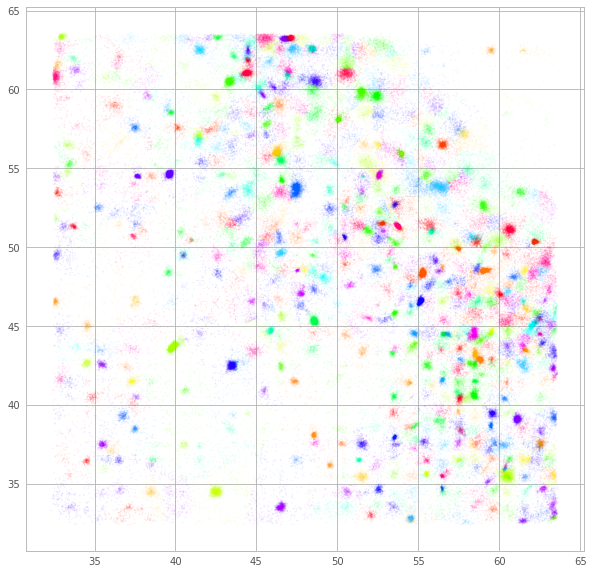

In [6]:
plt.figure(figsize=(10, 10))
H.PlotAll(invert=True, s=1, alpha=0.05)

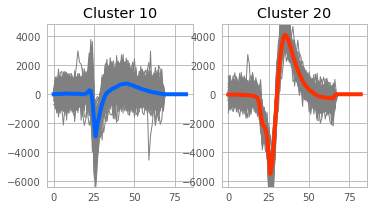

In [7]:
# Show a few units

units = (10,20)
H.PlotShapes(units)

402


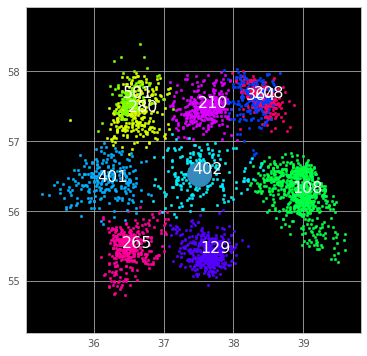

In [8]:
# sort by cluster size, select one, and plot in space
# unclustered spikes are shown in white

# which cluster should be shown
cluster_number = 400
radius = 1.5

plt.figure(figsize=(6,6))
ax = plt.axes(facecolor='k')
largest = np.argsort(H.clusters['Size']).values[::-1]
cl = largest[cluster_number]
print(cl)
cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]
dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<radius)[0]
for cl_t in clInds:
    cx, cy = H.clusters['ctr_x'][cl_t],H.clusters['ctr_y'][cl_t]
    inds = np.where(H.spikes.cl==cl_t)[0]
    x,y = H.spikes.x[inds],H.spikes.y[inds]
    plt.scatter(x,y,c=plt.cm.hsv(H.clusters['Color'][cl_t]), s=6,alpha=1)
    plt.text(cx-0.1,cy,str(cl_t), fontsize=16, color='w')
plt.axis('equal');
# slice out the unclustered spikes
# is there a better way?
cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<radius)[0][:1000]
plt.scatter(x[spInds], y[spInds], c='w', s=6, alpha=0.4)

# plt.scatter(H.clusters.ctr_x[cl], H.clusters.ctr_y[cl],marker='o',s=600)
plt.scatter(H.centerz[cl][0], H.centerz[cl][1],marker='o',s=600)

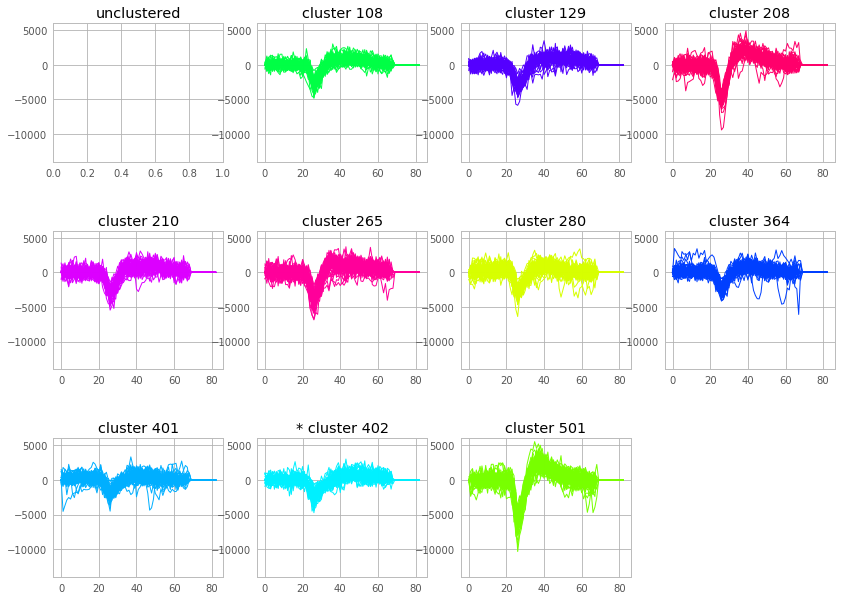

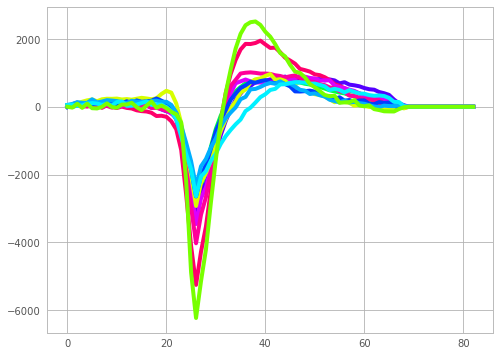

In [9]:
# waveforms for the spikes above
# * identifies the selected cluster above

plt.figure(figsize=(14,14))
cx, cy = H.clusters['ctr_x'][cl],H.clusters['ctr_y'][cl]
plt.subplot(4,4,1)
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<radius)[0][:20]
for i in inds[spInds]:
    plt.plot(H.spikes.Shape[i],'gray')
plt.ylim((-14000,6000))    
plt.title('unclustered')
dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<radius)[0]
for i,cl_t in enumerate(clInds[:15]):
    plt.subplot(4,4,i+2)
    spInds = np.where(H.spikes.cl==cl_t)[0]
    for i in spInds[:50]:
        plt.plot(H.spikes.Shape[i],color=plt.cm.hsv(H.clusters['Color'][cl_t]))#'k')
    plt.ylim((-14000,6000))    
    if cl_t==cl:
        plt.title('* cluster '+str(cl_t))
    else:
        plt.title('cluster '+str(cl_t))

plt.figure(figsize=(8,6))
inds = np.where(H.spikes.cl==-1)[0]
x,y = H.spikes.x[inds].values, H.spikes.y[inds].values
dists = np.sqrt((cx-x)**2+(cy-y)**2)
spInds = np.where(dists<radius)[0]
plt.plot(H.spikes.Shape[spInds].mean(),'gray',lw=4)
dists = np.sqrt((cx-H.clusters['ctr_x'])**2+(cy-H.clusters['ctr_y'])**2)
clInds = np.where(dists<radius)[0]
for i,cl_t in enumerate(clInds[:15]):
    spInds = np.where(H.spikes.cl==cl_t)[0]
    plt.plot(H.spikes.Shape[spInds].mean(),color=plt.cm.hsv(H.clusters['Color'][cl_t]), label=cl_t, lw=4)


In [10]:
# save the data to the old hdf5 format
# note cluster 0 are unclustered spikes

# H.Save_HDF5_legacy('out.hdf5')
